In [89]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy
import requests

## Walkability data

In [2]:
df_walk = pd.read_csv('../data/walkability.csv')

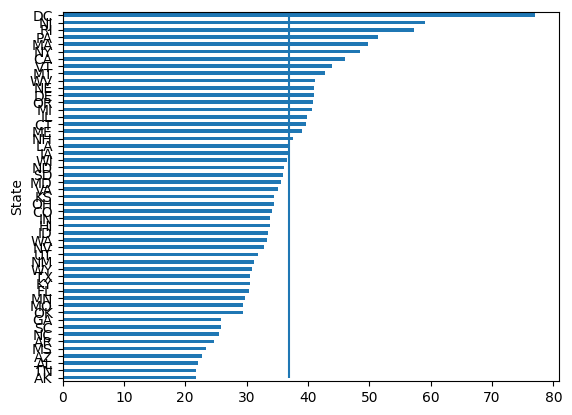

In [3]:
ax = (
    df_walk.groupby('State')['Walk Score'].mean()
    .sort_values(ascending=True)
    .plot
    .barh()
)

ax.vlines(df_walk['Walk Score'].mean(), 0, 1000)

## Activity (CDC) data

In [32]:
df_nutri = pd.read_csv("../data/nutrition_activity.csv")
df_nutri.drop(['Data_Value_Unit', 'Total', 'Data_Value_Type', 'GeoLocation'], axis=1, inplace=True)

In [33]:
df_nutri.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'Datasource',
       'Class', 'Topic', 'Question', 'Data_Value', 'Data_Value_Alt',
       'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
       'Low_Confidence_Limit', 'High_Confidence_Limit ', 'Sample_Size',
       'Gender', 'Grade', 'Race/Ethnicity', 'ClassID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'LocationID', 'StratificationCategory1',
       'Stratification1', 'StratificationCategoryId1', 'StratificationID1'],
      dtype='object')

In [34]:
df_nutri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40096 entries, 0 to 40095
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YearStart                   40096 non-null  int64  
 1   YearEnd                     40096 non-null  int64  
 2   LocationAbbr                40096 non-null  object 
 3   LocationDesc                40096 non-null  object 
 4   Datasource                  40096 non-null  object 
 5   Class                       40096 non-null  object 
 6   Topic                       40096 non-null  object 
 7   Question                    40096 non-null  object 
 8   Data_Value                  29460 non-null  float64
 9   Data_Value_Alt              29460 non-null  float64
 10  Data_Value_Footnote_Symbol  10636 non-null  object 
 11  Data_Value_Footnote         10636 non-null  object 
 12  Low_Confidence_Limit        29460 non-null  float64
 13  High_Confidence_Limit       294

In [41]:
df_nutri.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value,Data_Value_Alt,...,Race/Ethnicity,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2019,2019,AK,Alaska,Youth Risk Behavior Surveillance System,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who achieve...,9.6,9.6,...,Asian,PA,PA1,Q048,VALUE,2,Race/Ethnicity,Asian,RACE,RACEASN
1,2019,2019,AZ,Arizona,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,13.3,13.3,...,NaN,OWS,OWS1,Q038,VALUE,4,Total,Total,OVR,OVERALL
2,2019,2019,DC,District of Columbia,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,17.1,17.1,...,NaN,OWS,OWS1,Q038,VALUE,11,Total,Total,OVR,OVERALL
3,2019,2019,IL,Illinois,Youth Risk Behavior Surveillance System,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who partici...,65.9,65.9,...,NaN,PA,PA1,Q049,VALUE,17,Grade,10th,GRADE,GRADE10
4,2019,2019,MD,Maryland,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have an...,16.7,16.7,...,2 or more races,OWS,OWS1,Q039,VALUE,24,Race/Ethnicity,2 or more races,RACE,RACE2PLUS


Unique question in the dataset: 

|    | ClassID   | QuestionID   | Question                                                                                                                    |
|---:|:----------|:-------------|:----------------------------------------------------------------------------------------------------------------------------|
|  0 | FV        | Q020         | Percent of students in grades 9-12 who consume fruit less than 1 time daily                                                 |
|  1 | FV        | Q021         | Percent of students in grades 9-12 who consume vegetables less than 1 time daily                                            |
|  2 | OWS       | Q038         | Percent of students in grades 9-12 who have obesity                                                                         |
|  3 | OWS       | Q039         | Percent of students in grades 9-12 who have an overweight classification                                                    |
|  4 | PA        | Q048         | Percent of students in grades 9-12 who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily |
|  5 | PA        | Q049         | Percent of students in grades 9-12 who participate in daily physical education                                              |
|  6 | SD        | Q058         | Percent of students in grades 9-12 who drank regular soda/pop at least one time per day                                     |
|  7 | TV        | Q059         | Percent of students in grades 9-12 watching 3 or more hours of television each school day                                   |

(table generated with code: 
```python
print(df_nutri.groupby(["ClassID", "QuestionID"])["Question"]
      .unique()
      .reset_index()
      .explode("Question")
      .to_markdown())
```
)

ClassID: 
- FV: Fruit and vegetables
- OWS: Obesity and Weight Status
- PA: Physical activity
- SD: Soda drink consumption
- TV: TV watching behavior

In [140]:
vegetable_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'FV'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart = lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

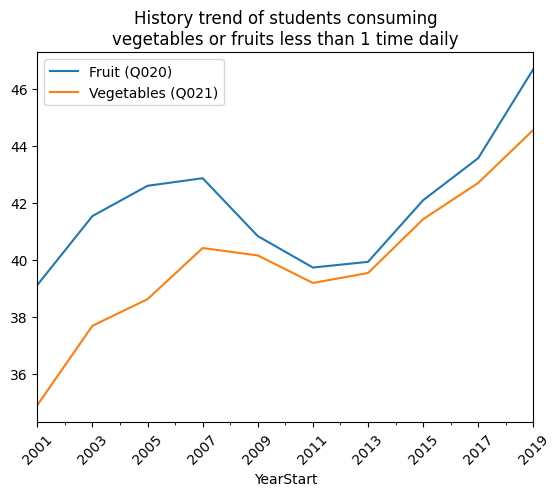

In [141]:
register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = vegetable_trend.plot.line(x='YearStart')
ax.set_title("History trend of students consuming\nvegetables or fruits less than 1 time daily")
xticks = pd.date_range(start=vegetable_trend['YearStart'].min(), end="2020-01-01", freq='2Y')
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime('%Y') for x in xticks], rotation=45)
L = plt.legend()
L.get_texts()[0].set_text('Fruit (Q020)')
L.get_texts()[1].set_text('Vegetables (Q021)')

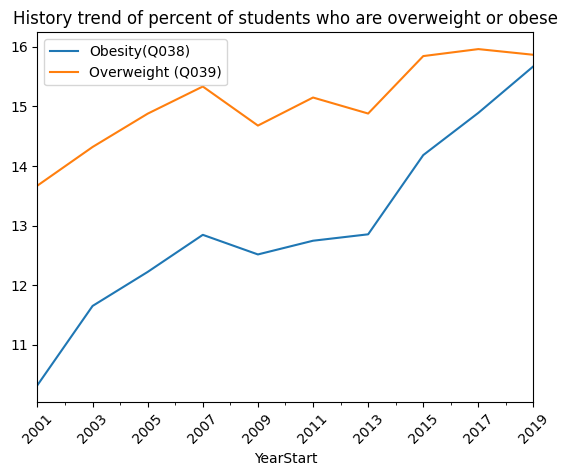

In [146]:
obesity_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'OWS'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart = lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = vegetable_trend.plot.line(x='YearStart')
ax.set_title("History trend of percent of students who are overweight or obese")
xticks = pd.date_range(start=vegetable_trend['YearStart'].min(), end="2020-01-01", freq='2Y')
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime('%Y') for x in xticks], rotation=45)
L = plt.legend()
L.get_texts()[0].set_text('Obesity(Q038)')
L.get_texts()[1].set_text('Overweight (Q039)')